## PickSeq RNASeq Data Analysis

**Transfer data from Imstor to scratch space within O2 server**

```bash
rsync -aPr ajn16@transfer.rc.hms.harvard.edu:/n/files/ImStor/sorger/data/rnaseq/ajit_johns
on/pick_rnaseq/raw_files .
```
***

**INTIAL QUALITY CONTROL**
**FASTQC ANALYSIS**

```bash
cd /n/scratch2/pick_rnaseq/
mkdir fastqc
cd fastqc
vim fastqc.run
```
***

```bash
#!/bin/bash
#SBATCH -p short                # partition name
#SBATCH -t 0-5:00               # hours:minutes runlimit after which job will be killed
#SBATCH -c 8                    # number of cores requested -- this needs to be greater than or equal to the number of cores you plan to use to run your job
#SBATCH --job-name fastqc       # Job name
#SBATCH -o %j.out               # File to which standard out will be written
#SBATCH -e %j.err               # File to which standard err will be written
#SBATCH --mail-type=END         # Type of email notification- BEGIN,END,FAIL,ALL
#SBATCH --mail-user=ajitj_nirmal@dfci.harvard.edu   # Email to which notifications will be sent


## Changing directories to where the fastq files are located
cd /n/scratch2/ajit/pick_rnaseq/raw_files

## Loading modules required for script commands
module load fastqc/0.11.5

## Running FASTQC
fastqc -t 8 *.fastq

## Move files 
mv *fastqc* ../fastqc
```
***

**Run the job**

```bash
sbatch fastqc.run
```

***
**The .html files contain the final reports generated by fastqc. Transfer the file over to your laptop via FileZilla**
***

Before trimming the sequences and running fastqc for the second time, move the fastqc files into a new directory.

```bash
mkdir round1
mv *fastqc* round1/
```
***

**MultiQC analysis for aggregateing results across many samples into a single report**

```bash
cd round1/
module load gcc/6.2.0  python/2.7.12 multiqc/1.5
multiqc .
```

***
**Download the reference**

```bash
mkdir reference
wget ftp://ftp.ensembl.org/pub/release-96/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz
wget ftp://ftp.ensembl.org/pub/release-96/gtf/homo_sapiens/Homo_sapiens.GRCh38.96.gtf.gz
```

***
**Prepare the configuration/yaml file**

```bash
cd for_alignment
wget https://labsyspharm.github.io/rnaseq/example_settings/rna_seq/O2.yaml
vim O2.yaml

details:
  - analysis: RNA-seq
    genome_build: hg38
    algorithm:
      transcriptome_fasta: /n/scratch2/ajit/pick_rnaseq/reference/Homo_sapiens.GRCh38.cdna.all.fa
      transcriptome_gtf: /n/scratch2/ajit/pick_rnaseq/reference/Homo_sapiens.GRCh38.96.gtf
      aligner: hisat2
      strandedness: unstranded
upload:
  dir: ../final
```

***
**Create a sample description file**

```bash
cd for_alignment
(echo 'samplename,description'; for f in for_alignment/*fastq*; do readlink -f $f | perl -pe 's/(.*?_(S[0-9]+)_.*)/\1,\2/'; done) > alignment.csv 
```
***

**Intiate bcBio**

```bash
module load bcbio/latest
unset PYTHONPATH
bcbio_nextgen.py -w template O2.yaml alignment.csv for_alignment/
```
***

**Run bcBio**
```bash
cd alignment/work
vim submit_bcbio.sh

#!/bin/sh
#SBATCH -p medium
#SBATCH -J bcbio_O2
#SBATCH -o run.o
#SBATCH -e run.e
#SBATCH -t 1-00:00
#SBATCH --cpus-per-task=3
#SBATCH --mem=8000
#SBATCH --mail-type=END         # Type of email notification- BEGIN,END,FAIL,ALL
#SBATCH --mail-user=ajitj_nirmal@dfci.harvard.edu   # Email to which notifications will be sent

export PATH=/n/app/bcbio/tools/bin:$PATH
bcbio_nextgen.py ../config/alignment.yaml \
    -n 24 -t ipython -s slurm -q medium -r t=1-00:00 --timeout 2000
    
sbatch submit_bcbio.sh
```
***

**Create the R data file for quality assessment of the counts data generated**

```bash
cd /n/scratch2/ajit/pick_rnaseq/alignment/
mkdir Rresults

srun --pty -p interactive --mem 15G -t 0-01:00 /bin/bash
module load gcc/6.2.0 R/3.5.1
R
```

```R
setwd("/n/scratch2/ajit/pick_rnaseq/alignment/Rresults")
library(bcbioRNASeq)
bcb <- bcbioRNASeq(
    uploadDir = "/n/scratch2/ajit/pick_rnaseq/alignment/final",
    interestingGroups = c("tissue", "cells", "prep"),
)

saveData(bcb, dir = ".")
```
***

**Go down for plot related scripts**

***

**Trimming the reads using trimmomatic**

```bash
rm -r for_alignment/
mkdir for_alignment
cp -r /n/scratch2/ajit/pick_rnaseq/raw_files/* /n/scratch2/ajit/pick_rnaseq/for_alignment

vim auto_trim.sh

module load trimmomatic/0.36

# Execution
# Case(1) run on a couple of PE files with extension *.fq
# $ sh auto_trim.sh *.fastq

red=`tput setaf 1`
green=`tput setaf 2`
yellow=`tput setaf 3`
reset=`tput sgr0`
count=0

usage ()
{
  echo -e "${green}Usage: sh auto_trim [*.extension]\n \
      extension: <fq> or <fastq> or <fq.gz> or <fastq.gz>\n \
      example: sh auto_trim.sh *.fq.gz\n ${reset}\n\
${yellow}Help:  sh autotrim -h or --help${reset}"
  exit
}

file_not_found ()
{
echo -e "\n${red}FileNotFoundError: No such file with extension $@ found!${reset}"
echo -e "${green}Supported extensions are: <.fq> or <.fastq> or <.fq.gz> or <.fastq.gz>${reset}\n"
exit 
}

file_name_error ()
{
echo -e "\n${red}Filename Error: Paired end file names should contain _R1 _R2${reset}"
echo -e "${green}Example: test_R1.fq.gz, test_R2.fq.gz${reset}\n"
exit 
}

file_extension_error ()
{
echo -e "\n${red}FileExtensionError: Invalid extension${reset}"
echo -e "${green}Supported extensions are: <.fq> or <.fastq> or <.fq.gz> or <.fastq.gz>${reset}\n"
exit     
}

if [[ ( $1 == '-h' ) || ( $1 == '--help') ]] ;then
 usage
elif [[ $# -eq 0 ]] ;then
 echo "${red}Error: No parameter(s) provided${reset}"
 usage
 exit 0
else
  for i in $@; do
        count=$((count+1))
        if [ -f $i ] ;then
            if [[ (${i#*.} == "fastq.gz") || (${i#*.} == "fq.gz") || (${i#*.} == "fastq") || (${i#*.} == "fq") ]] ;then 
                if echo $1 | grep -q -e "_R1" -e "_R2"; then
		   if [[ $count%2 -ne 0 ]]; then
                       sample_name=`echo $i | awk -F "_R1"  '{print $1}'`
                       extension=`echo $i | awk -F "_R1"  '{print $2}'`
                       R1=${sample_name}_R1${extension}
	               R2=${sample_name}_R2${extension}
		       R1_pair=${sample_name}_R1_pair${extension}
		       R1_unpair=${sample_name}_R1_unpair${extension}
		       R2_pair=${sample_name}_R2_pair${extension}
		       R2_unpair=${sample_name}_R2_unpair${extension}
                       echo -e "\n${yellow}[Running trimmomatic for sample] ${sample_name} at `whoami`${reset}\n"
                       date && time java -jar $TRIMMOMATIC/trimmomatic-0.36.jar \
                       PE \
                       $R1 $R2 $R1_pair $R1_unpair $R2_pair $R2_unpair \
                       HEADCROP:7 \
                       LEADING:20 \
                       TRAILING:20 \
                       SLIDINGWINDOW:20:20 \
                       MINLEN:50 
                       rm *unpair*

                   fi
                else file_name_error
                fi      
            elif [[ (${i#*.} == "sh") || (${i#*.} == "sh~")  ]] ;then
                 echo -n
            else
                echo -ne "${red}Check:$i${reset}"
                file_extension_error  
            fi     
        else
	    file_not_found $@
        fi
  done
fi
```

***

**Run Trimmomatic**

```bash
sh auto_trim.sh *.fastq
```
***
**Run Alignment**

```bash
cd for_alignment
find . -type f \! -name "*pair*" -delete


# Change the file names so that the old alignment.csv can be used
for filename in *.fastq; do 
    [ -f "$filename" ] || continue
    mv "$filename" "${filename//_pair/}"
done
```
cd ..
module load bcbio/latest
unset PYTHONPATH
bcbio_nextgen.py -w template O2.yaml alignment.csv for_alignment/

#bash
cd alignment/work
vim submit_bcbio.sh

#!/bin/sh
#SBATCH -p medium
#SBATCH -J bcbio_O2
#SBATCH -o run.o
#SBATCH -e run.e
#SBATCH -t 1-00:00
#SBATCH --cpus-per-task=3
#SBATCH --mem=8000
#SBATCH --mail-type=END         # Type of email notification- BEGIN,END,FAIL,ALL
#SBATCH --mail-user=ajitj_nirmal@dfci.harvard.edu   # Email to which notifications will be sent

export PATH=/n/app/bcbio/tools/bin:$PATH
bcbio_nextgen.py ../config/alignment.yaml \
    -n 24 -t ipython -s slurm -q medium -r t=1-00:00 --timeout 2000
    
sbatch submit_bcbio.sh
```


**Generating Plots**

```bash
srun --pty -p interactive --mem 15G -t 0-01:00 /bin/bash
module load gcc/6.2.0 R/3.5.1
R

cd /n/scratch2/ajit/pick_rnaseq/alignment/final
```

```R
library(ggplot2)
library(cowplot)
library(DESeq2)
library(DEGreport)
library(bcbioRNASeq)

theme_set(
    theme_gray(base_size = 10)
)

bcb <- bcbioRNASeq(
    uploadDir = ".",
    interestingGroups = "region"
)



lv = gtools::mixedsort(as.character(colData(bcb)[["sampleName"]]))
colData(bcb)[["sampleName"]] = factor(colData(bcb)[["sampleName"]], levels = lv)
lv = unique(gtools::mixedsort(as.character(colData(bcb)[["prep"]])))
colData(bcb)[["prep"]] = factor(colData(bcb)[["prep"]], levels = lv)
interestingGroups(bcb) = "prep"
saveData(bcb)

setwd("/n/scratch2/ajit/pick_rnaseq/alignment/Rresults")
bcb <- readRDS("bcb.rds")

# Figure 1 ====
theme_update(
    legend.justification = "left",
    legend.position = "right"
)
pdf("generalStats.pdf", width = 9, height = 7)
plot_grid(
    plotTotalReads(bcb),
    plotMappingRate(bcb),
    plotExonicMappingRate(bcb),
    plotIntronicMappingRate(bcb),
    plotGenesDetected(bcb),
    plotGeneSaturation(bcb),
    ncol = 2,
    labels = "AUTO",
    label_size = 12
)
dev.off()


# Figure 2 ====
theme_update(
    legend.justification = "center",
    legend.position = "bottom"
)
pdf("geneCounts.pdf", width = 8, height = 4)
plot_grid(
    plotCountsPerGene(bcb),
    plotCountDensity(bcb),
    ncol = 2,
    labels = "AUTO",
    label_size = 14
)
dev.off()


# Figure 3 ====
pdf("plotMeanSD.pdf", width = 8, height = 4)
plotMeanSD(bcb)
dev.off()



# Figure 4 ====
pdf("plotDispEsts.pdf", width = 6, height = 6)
plotDispEsts(bcb)
dev.off()



# Figure 5 ====
pdf("plotCorrelationHeatmap.pdf", width = 6, height = 6)
plotCorrelationHeatmap(bcb)
dev.off()



# Figure 6 ====
pdf("plotPCA.pdf", width = 6, height = 4)
plotPCA(bcb, label = FALSE)
dev.off()



# Figure 7 ====
pdf("plotPCACovariates.pdf", width = 8, height = 5)
plotPCACovariates(bcb)
dev.off()



dds <- as(bcb, "DESeqDataSet")
design(dds) <- ~cells
dds <- DESeq(dds)

res <- results(
    dds,
    name = "cells_ck_vs_CD8 T cell",
    alpha = 0.05)


alphaSummary(dds, contrast = c("cells", "ck", "CD8 T cell"), alpha = c(0.1, 0.05))

# Figure 8 ====
pdf("plotMA.pdf", width = 6, height = 6)
plotMeanAverage(res)
dev.off()



# Figure 9 ====
pdf("plotVolcano.pdf", width = 6, height = 6)
plotVolcano(res)
dev.off()



# Figure 10 ====
pdf("plotDEGHeatmap.pdf", width = 6, height = 6)
# DESeqResults, DESeqTransform
plotDEGHeatmap(res, counts = bcb, normalized = "vst")
dev.off()



# Figure 11 ====
pdf("degPlot.pdf", width = 6, height = 3)
degPlot(
    object = bcb,
    res = res,
    n = 3,
    slot = "vst",
    log = FALSE,
    # Use the 'ann' argument for gene to symbol mapping
    ann = c("geneID", "geneName"),
    xs = "day")
dev.off()



dds_lrt <- DESeq(dds, test = "LRT", reduced = ~1)
res_lrt <- results(dds_lrt)
saveData(dds_lrt, res_lrt)



theme_set(
    theme_gray(base_size = 5)
)
ma <- counts(bcb, "rlog")[significants(res, fc = 2), ]
res_patterns <- degPatterns(
    ma,
    metadata = colData(bcb),
    time = "day",
    minc = 60)
saveData(dds_lrt, res_lrt, res_patterns)


# Figure 12 ====

pdf("figures/degPatterns.pdf", width = 8, height = 4)
res_patterns[["plot"]]
dev.off()



# Subset example
subset(res_patterns[["df"]], cluster == 8, select = "genes")

res_tbl <- resultsTables(res, lfc = 1)
topTables(res_tbl, n = 5)

# FA analysis
library(clusterProfiler)
sigGenes <- significants(res, fc = 1, padj = 0.05)
allGenes <- rownames(res)[!is.na(res[["padj"]])]
sigResults <- as.data.frame(res)[sigGenes, ]
foldChanges <- sigResults$log2FoldChange
names(foldChanges) <- rownames(sigResults)

ego <- enrichGO(
    gene = sigGenes,
    OrgDb = "org.Mm.eg.db",
    keyType = "ENSEMBL",
    ont = "BP",
    universe = allGenes,
    qvalueCutoff = 0.05,
    readable = TRUE
)

pdf("figures/dot_plot.pdf", width = 7, height = 5)
dotplot(ego, showCategory = 25)
dev.off()
pdf("figures/enrich_map.pdf", width = 6, height = 6)
emapplot(ego, n = 25)
dev.off()
pdf("figures/cnet_plot.pdf", width = 6, height = 6)
cnetplot(
    ego,
    categorySize = "pvalue",
    showCategory = 5,
    foldChange = foldChanges,
    node_label = FALSE,
)
dev.off()

```

## Differential gene expression analysis

In [7]:
# Import packages
# Project specific libraries
library(limma)
library(DESeq2)
library(reshape2)
library(ggplot2)
library(cowplot)
library("pheatmap")
library("RColorBrewer")
library(biomaRt)
library(tidyr)
library(dplyr)

# Import Lib for exixting scripts
library(devtools)
library(roxygen2)

# set WD

# MAC
#setwd ("/Users/aj/Dropbox (Partners HealthCare)/Data/PickSeq_RnaSeq/")

In [141]:
# Import data
data <- read.csv("combined.counts", header=T, sep="", row.names = 1)
pdata <- read.table("metadata.csv", header=T, sep=",",row.names = 1)
dim(data)

# Download ENSEMBL-GENE mapping
ensembl = useEnsembl(biomart="ensembl", dataset="hsapiens_gene_ensembl")
genes <- getBM(attributes=c('ensembl_gene_id','hgnc_symbol'), mart = ensembl)

# Merge data
data_m = merge(data, genes, by.x="row.names", by.y= "ensembl_gene_id")
head(data_m)

Warning message in file(file, "rt"):
"cannot open file 'combined.counts': No such file or directory"

ERROR: Error in file(file, "rt"): cannot open the connection


In [28]:
#Prepare data for collating multiple transcripts into one gene
data_merged <- data_m[,-1]
names(data_merged)[names(data_merged) == 'hgnc_symbol'] <- 'gene'
head(data_merged)

S21,S22,S9,S15,S4,S18,S29,S20,S23,S19,⋯,S25,S17,S14,S30,S12,S27,S6,S13,S16,gene
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
0,0,11,79,0,0,0,0,0,0,⋯,0,0,5,0,13,0,0,66,5,TSPAN6
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,TNMD
0,0,3,71,0,0,0,2,0,0,⋯,2,3,0,0,11,6,0,10,9,DPM1
0,0,2,16,0,0,1,7,0,0,⋯,0,3,0,0,9,0,0,14,8,SCYL3
0,0,0,1,0,0,0,7,0,0,⋯,0,2,0,0,0,1,0,0,8,C1orf112
0,0,16,0,0,0,0,0,0,0,⋯,0,0,0,0,6,0,0,0,7,FGR


In [31]:
#Merge multiple transcripts into one gene
# Import function
source_url("https://raw.githubusercontent.com/ajitjohnson/Jupyter-Notebooks/master/r_scripts/collapse_to_one_gene.R")
# Merge
data_merged <- genesummary (data_merged)
dim(data_merged)
head(data_merged)

SHA-1 hash of file is a0c6a4622daa5b3775f335059a29d6224d9f4032


[1] 37536    30

,S21,S22,S9,S15,S4,S18,S29,S20,S23,S19,⋯,S28,S25,S17,S14,S30,S12,S27,S6,S13,S16
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
,68,44,90,147,268,2,55,43,10,243,⋯,61,47,25,149,1,76,25,315,134,35
A1BG,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,13,0,0,0,0,0,0
A1BG-AS1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
A1CF,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
A2M,0,0,5,1,19,0,2,0,0,0,⋯,0,0,9,3,0,15,0,0,14,33
A2M-AS1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,32,0,0


In [34]:
# Write out the data to continue analysis via the python pipeline
write.csv(data_merged, file = "T2_counts_genenames.csv",sep = ",")

Warning message in write.csv(data_merged, file = "counts_genenames.csv", sep = ","):
“attempt to set 'sep' ignored”

In [2]:
# Read dataset
#setwd("C:/Users/ajn16/Dropbox (Partners HealthCare)/Data/PickSeq_RnaSeq")
setwd("/Users/aj/Dropbox (Partners HealthCare)/Data/PickSeq_RnaSeq")
data <- read.table(file = "T2_counts_genenames.csv", sep=',', header = T, row.names = 1)
pdata <- read.table("metadata.csv", header=T, sep=",",row.names = 1)

In [3]:
# Split them into tissue specific datasets
tonsil <- row.names(pdata[which(pdata$tissue == "Tonsil"),])
breast <- row.names(pdata[which(pdata$tissue == "Breast"),])

tonsil_exp <- data[,tonsil]
tonsil_pdata <- pdata[tonsil,]

breast_exp <- data[,breast]
breast_pdata <- pdata[breast,]

In [186]:
# Analysis of the tonsil tissues

# DESeq analaysis
dds_tonsil <- DESeqDataSetFromMatrix(countData = tonsil_exp, colData = tonsil_pdata, design = ~ cells)
dds_tonsil <- DESeq(dds_tonsil)

# Normalize the data by rlog method for other analysis
rld_tonsil<- rlog(dds_tonsil, blind=FALSE)
vsd_tonsil <- vst(dds_tonsil, blind=FALSE)

# Extract the normalised data from the deseq file
n_data_tonsil <- data.frame(assay(rld_tonsil))
head(n_data_tonsil)

factor levels were dropped which had no samples
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]
estimating size factors
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in

,S21,S22,S29,S20,S23,S26,S24,S28,S25,S27
A1BG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A1BG-AS1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A1CF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A2M,-1.983624,-1.990575,-1.659339,-1.990988,-1.860732,-2.003429,-1.954439,-1.969336,-1.949356,-1.955234
A2M-AS1,-2.232632,-2.234979,-2.225508,-2.235119,-2.191123,-2.188117,-2.222774,-2.227806,-2.221057,-2.223043
A2ML1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


SHA-1 hash of file is ea705fcd7367ec2f0f16b7660c0ae5b75421a27c
No id variables; using all as measure variables
No id variables; using all as measure variables
Warning message:
"Removed 328398 rows containing non-finite values (stat_boxplot)."

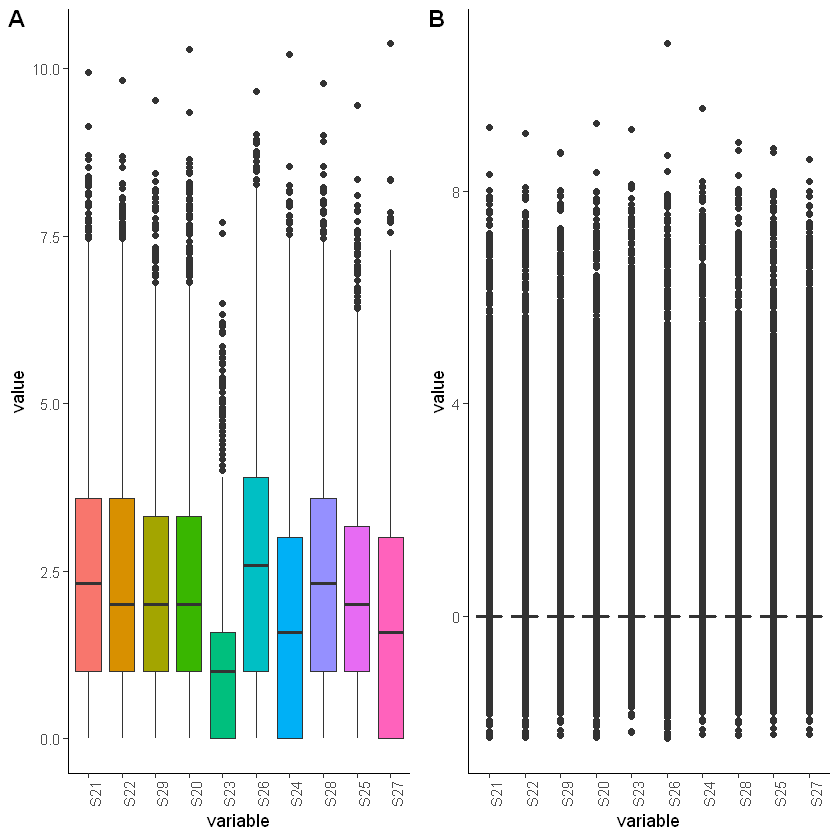

In [17]:
source_url("https://raw.githubusercontent.com/ajitjohnson/Jupyter-Notebooks/master/r_scripts/plot_before_after_normalization.R")
plotba (tonsil_exp,n_data_tonsil)

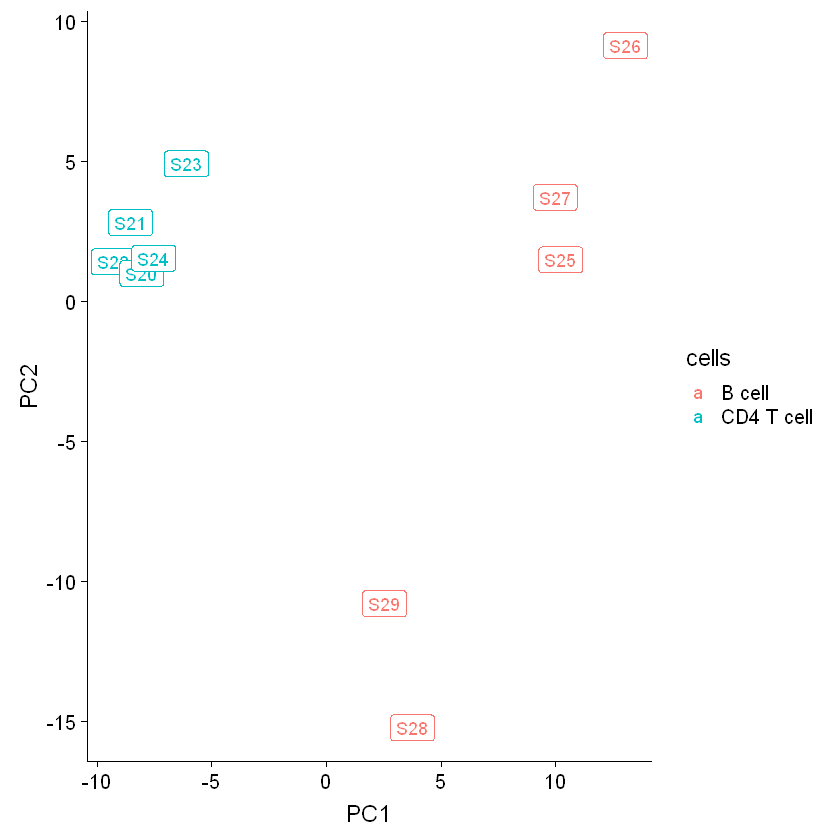

In [39]:
pcaData <- plotPCA(rld_tonsil, intgroup= "cells", returnData=TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))
ggplot(pcaData, aes(PC1, PC2, color=cells)) + geom_point(size=3) + geom_label(aes(label = name))

In [187]:
# Differentially expressed genes
res_tonsil <- results(dds_tonsil)
res_tonsil <- res_tonsil[order(res_tonsil$padj),]
summary(res_tonsil)


out of 12896 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 40, 0.31%
LFC < 0 (down)     : 81, 0.63%
outliers [1]       : 408, 3.2%
low counts [2]     : 9869, 77%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



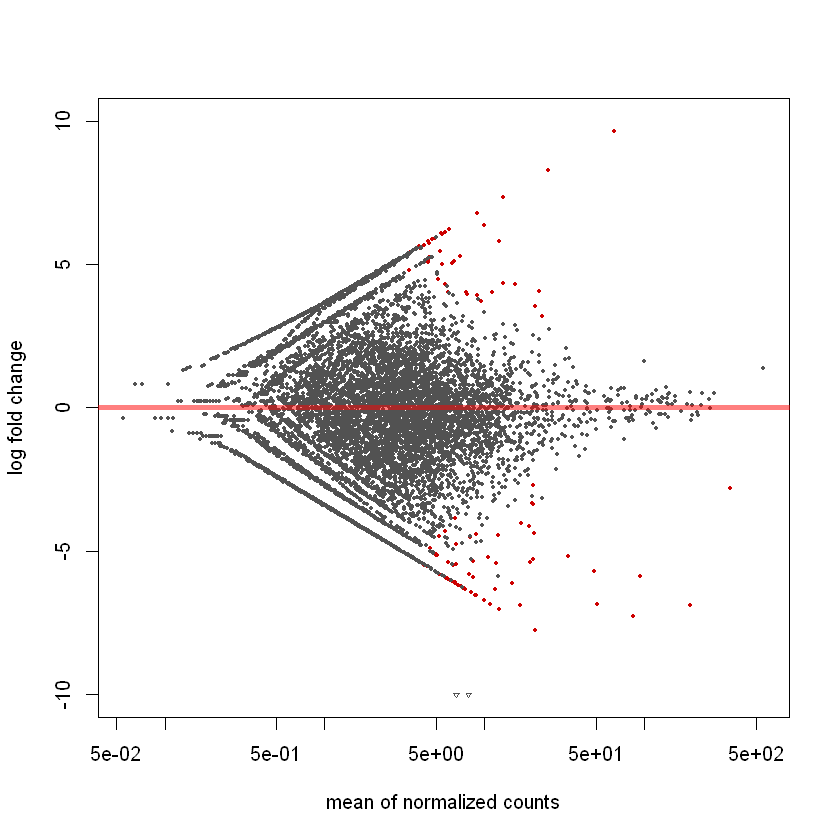

In [43]:
plotMA(res_tonsil, ylim=c(-10,10))

In [188]:
head(res_tonsil)

log2 fold change (MLE): cells CD4.T.cell vs B.cell 
Wald test p-value: cells CD4.T.cell vs B.cell 
DataFrame with 6 rows and 6 columns
                  baseMean    log2FoldChange            lfcSE              stat
                 <numeric>         <numeric>        <numeric>         <numeric>
CCL21     65.1850854548631  9.64625351371356  1.3888070590562  6.94571175370389
CCL19     25.0858337384633  8.27606032854474 1.43636557212886  5.76180638768627
MS4A1     85.7002872617075 -7.27370809977858 1.32596078874106 -5.48561327117722
CD19      20.8151775033554 -7.77500030661611 1.44970680459433 -5.36315362663402
FDCSP     94.1240638943091 -5.87525389607151 1.12330388589296 -5.23033345638346
TNFRSF13C 16.8775814343552 -6.88623170631827 1.39084845947764 -4.95110136506499
                        pvalue                 padj
                     <numeric>            <numeric>
CCL21     3.76556931225858e-12 9.86202602880521e-09
CCL19      8.3218428903739e-09 1.08974532649446e-05
MS4A1      4.1203

In [46]:
# Export normalized matrix
write.csv(n_data_tonsil, file = "results/T2_tonsil_normalized.csv")
# Export DEG matrix
write.csv(res_tonsil, file = "results/T2_tonsil_DEG.csv")

In [189]:
# Identify the diffrentially expressed genes and build a heat map
only_deg <- res_tonsil[ which(res_tonsil$padj <= 0.05), ]
# Order by foldchange
only_deg <- only_deg[order(only_deg$log2FoldChange),] 
# Subset expression data
DEGs <- n_data_tonsil[row.names(only_deg),]

In [190]:
# Create the grouping for coloring by disease
combined = merge(t(DEGs), tonsil_pdata, by="row.names")

# Order the data
combined= combined[order(combined$cells),]

# Retreive the data from the combined dataset
dd = combined[ , !(names(combined) %in% c("batch", "cells", "phenotype", "prep", "tissue"))]
row.names(dd) <- dd[,1]
dd <- dd[,-1]
dd = as.matrix(dd)

# Create the grouping for coloring by disease
my_group = factor(combined$cells)
my_col = brewer.pal(length(levels(factor(combined$cells))), "Set1")[my_group]

# Color pallet for heatmap
coul = colorRampPalette(brewer.pal(9,"OrRd"))(10)

Warning message in brewer.pal(length(levels(factor(combined$cells))), "Set1"):
"minimal value for n is 3, returning requested palette with 3 different levels
"

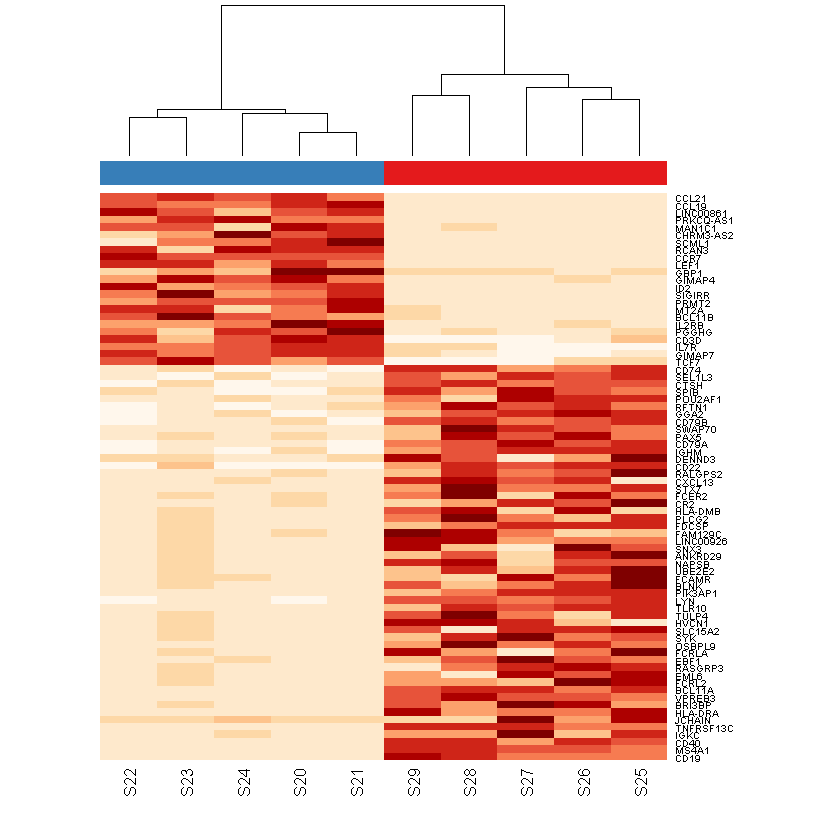

In [191]:
# Draw heat map
heatmap(t(dd), Rowv = NA, scale="row", ColSideColors=my_col, col =coul, hclustfun = hclust)

## # Analysing the breast  samples

In [4]:
# Seperate the dataset into three parts and do DESeq on those
p_tvcd8 <- breast_pdata[which(breast_pdata$cells %in% c("ck","CD8 T cell")),]
p_tvtil <- breast_pdata[which(breast_pdata$cells %in% c("ck","TIL")),]
p_cd8vtil <- breast_pdata[which(breast_pdata$cells %in% c("TIL","CD8 T cell")),]

# expression matrix
b_tvcd8 <-breast_exp[,row.names(p_tvcd8)]
b_tvtil <-breast_exp[,row.names(p_tvtil)]
b_cd8vtil <-breast_exp[,row.names(p_cd8vtil)]

## Tumor vs CD8 T cells

factor levels were dropped which had no samples
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]
estimating size factors
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in

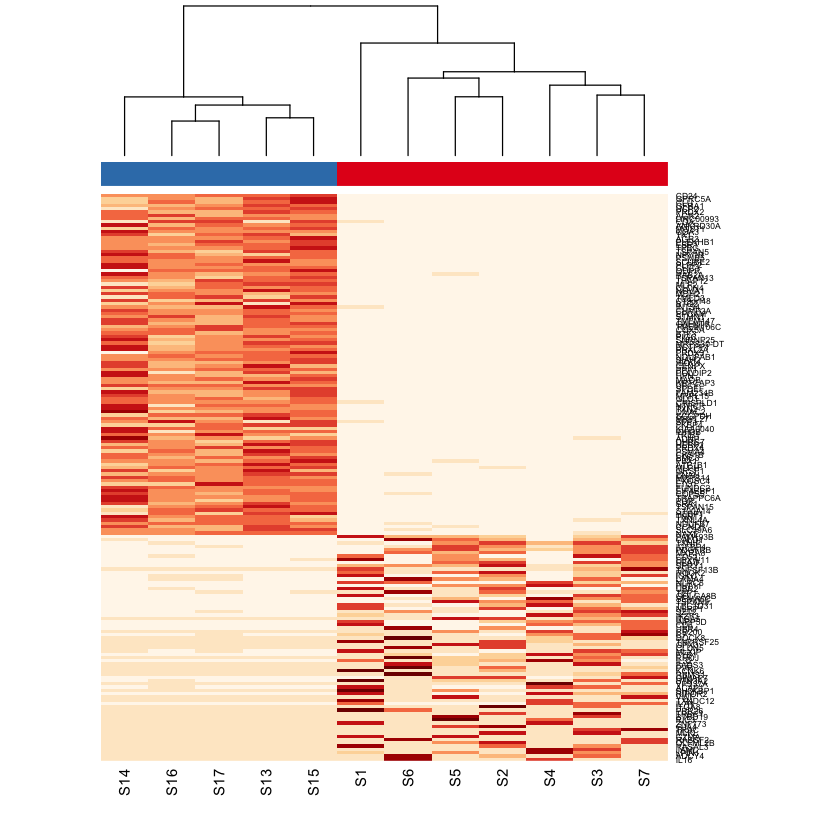

In [17]:
# Analysing the breast FFPE samples
# DESeq analaysis
dds <- DESeqDataSetFromMatrix(countData = b_tvcd8, colData = p_tvcd8, design = ~ cells)
dds <- DESeq(dds)

# Normalize the data by rlog method for other analysis
rld <- rlog(dds, blind=FALSE)

# Extract the normalised data from the deseq file
n_data <- data.frame(assay(rld))

# Differentially expressed genes
res <- results(dds)
res <- res[order(res$padj),]

# Identify the diffrentially expressed genes and build a heat map
only_deg <- res[ which(res$padj <= 0.05), ]
# Order by foldchange
only_deg <- only_deg[order(only_deg$log2FoldChange),] 
# Subset expression data
DEGs <- n_data[row.names(only_deg),]

# Create the grouping for coloring by disease
combined = merge(t(DEGs), p_tvcd8, by="row.names")

# Order the data
combined= combined[order(combined$cells),]

# Retreive the data from the combined dataset
dd = combined[ , !(names(combined) %in% c("batch", "cells", "phenotype", "prep", "tissue"))]
row.names(dd) <- dd[,1]
dd <- dd[,-1]
dd = as.matrix(dd)

# Create the grouping for coloring by disease
my_group = factor(combined$cells)
my_col = brewer.pal(length(levels(factor(combined$cells))), "Set1")[my_group]

# Color pallet for heatmap
coul = colorRampPalette(brewer.pal(9,"OrRd"))(10)

# Draw heat map
heatmap(t(dd), Rowv = NA, scale="row", ColSideColors=my_col, col =coul, hclustfun = hclust)

# Write out the differentially expressed genes
write.csv(only_deg, file = "results/DEG_Tumor vs CD8.csv")


## Tumor vs TIL

factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
Warning message in brewer.pal(length(levels(factor(combined$cells))), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”

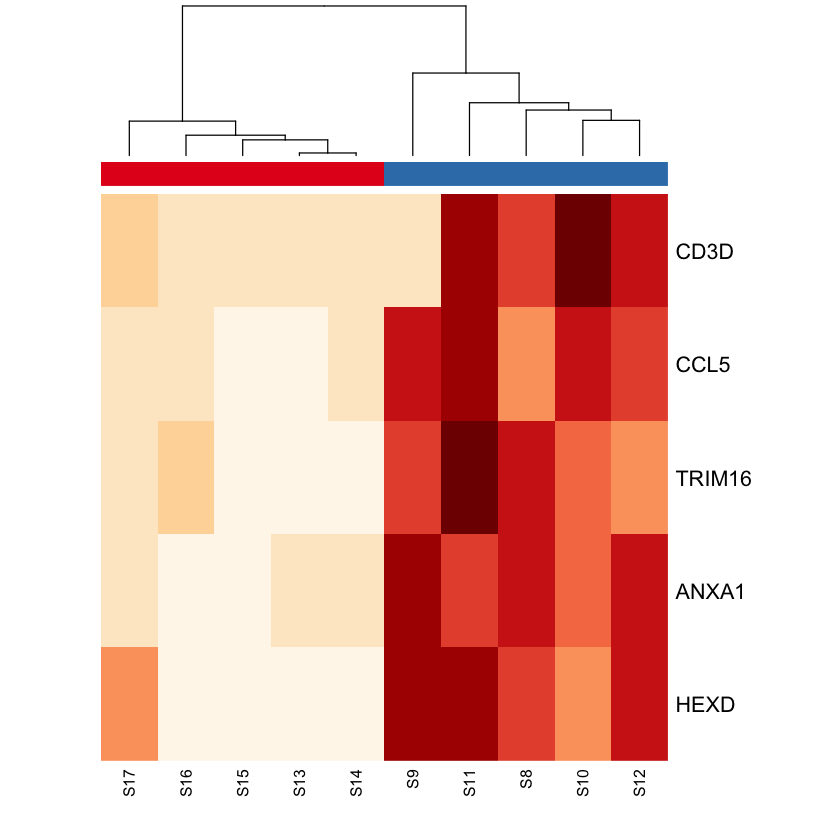

In [18]:
# Analysing the breast FFPE samples
# DESeq analaysis
dds <- DESeqDataSetFromMatrix(countData = b_tvtil, colData = p_tvtil, design = ~ cells)
dds <- DESeq(dds)

# Normalize the data by rlog method for other analysis
rld <- rlog(dds, blind=FALSE)

# Extract the normalised data from the deseq file
n_data <- data.frame(assay(rld))

# Differentially expressed genes
res <- results(dds)
res <- res[order(res$padj),]

# Identify the diffrentially expressed genes and build a heat map
only_deg <- res[ which(res$padj <= 0.05), ]
# Order by foldchange
only_deg <- only_deg[order(only_deg$log2FoldChange),] 
# Subset expression data
DEGs <- n_data[row.names(only_deg),]

# Create the grouping for coloring by disease
combined = merge(t(DEGs), p_tvtil, by="row.names")

# Order the data
combined= combined[order(combined$cells),]

# Retreive the data from the combined dataset
dd = combined[ , !(names(combined) %in% c("batch", "cells", "phenotype", "prep", "tissue"))]
row.names(dd) <- dd[,1]
dd <- dd[,-1]
dd = as.matrix(dd)

# Create the grouping for coloring by disease
my_group = factor(combined$cells)
my_col = brewer.pal(length(levels(factor(combined$cells))), "Set1")[my_group]

# Color pallet for heatmap
coul = colorRampPalette(brewer.pal(9,"OrRd"))(10)

# Draw heat map
heatmap(t(dd), Rowv = NA, scale="row", ColSideColors=my_col, col =coul, hclustfun = hclust)

# Write out the differentially expressed genes
write.csv(only_deg, file = "results/T2_DEG_Tumor vs TIL.csv")


## CD8 T cells vs TIL's

factor levels were dropped which had no samples
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]
estimating size factors
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in

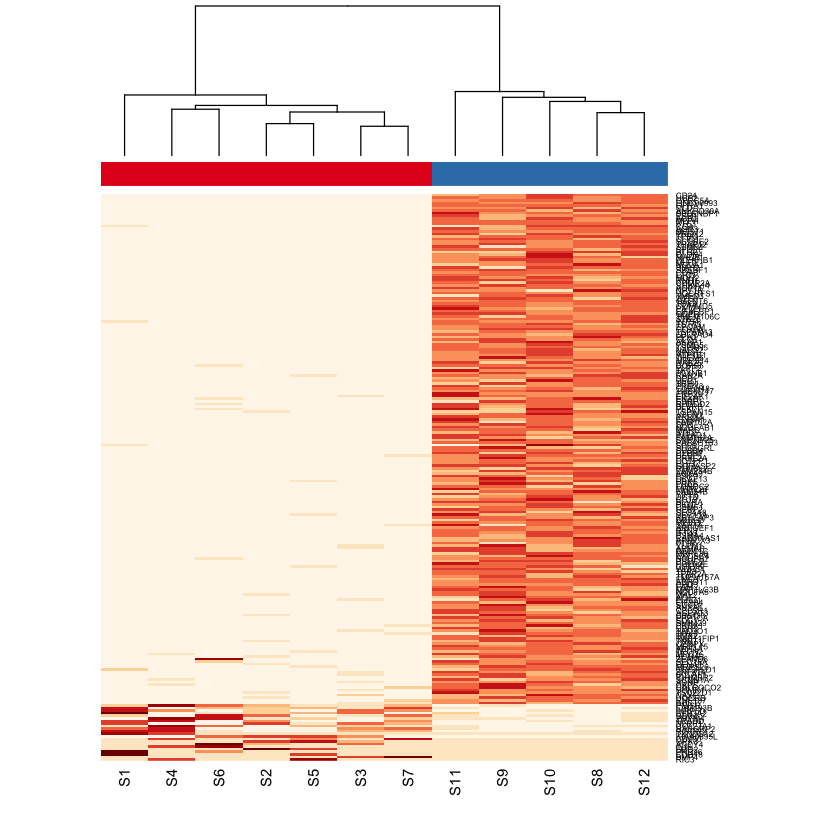

In [19]:
# Analysing the breast FFPE samples
# DESeq analaysis
dds <- DESeqDataSetFromMatrix(countData = b_cd8vtil, colData = p_cd8vtil, design = ~ cells)
dds <- DESeq(dds)

# Normalize the data by rlog method for other analysis
rld <- rlog(dds, blind=FALSE)

# Extract the normalised data from the deseq file
n_data <- data.frame(assay(rld))

# Differentially expressed genes
res <- results(dds)
res <- res[order(res$padj),]

# Identify the diffrentially expressed genes and build a heat map
only_deg <- res[ which(res$padj <= 0.05), ]
# Order by foldchange
only_deg <- only_deg[order(only_deg$log2FoldChange),] 
# Subset expression data
DEGs <- n_data[row.names(only_deg),]

# Create the grouping for coloring by disease
combined = merge(t(DEGs), p_cd8vtil, by="row.names")

# Order the data
combined= combined[order(combined$cells),]

# Retreive the data from the combined dataset
dd = combined[ , !(names(combined) %in% c("batch", "cells", "phenotype", "prep", "tissue"))]
row.names(dd) <- dd[,1]
dd <- dd[,-1]
dd = as.matrix(dd)

# Create the grouping for coloring by disease
my_group = factor(combined$cells)
my_col = brewer.pal(length(levels(factor(combined$cells))), "Set1")[my_group]

# Color pallet for heatmap
coul = colorRampPalette(brewer.pal(9,"OrRd"))(10)

# Draw heat map
heatmap(t(dd), Rowv = NA, scale="row", ColSideColors=my_col, col =coul, hclustfun = hclust)


# Write out the differentially expressed genes
write.csv(only_deg, file = "results/T2_DEG_CD8 vs TIL.csv")
